## **Introduction to Molecular Simulations using CP2K and ASE**

Below steps outline a minimal working example to simulate Hydrophosphoric acid interaction with water.

### **AIM: Hydrophosphoric acid interaction with water**

### 1. Optional

#### Create a virtual environment and install required packages. 

In [37]:
# Create a virtual environment using: python3 -m venv ~/.venv-ase-cp2k . Then pip3 install jupyterhub jupyterlab.
# Then open this notebook using jupyter-notebook notebookname.ipynb
#! pip3 install ase==3.25.0 mdanalysis==2.9.0
#! pip3 install nglview==3.1.4
#! pip3 install jupyter-ai[all]

#### Install cp2k

In [38]:
# ! sudo apt-get install cp2k

### 2. Import required libraries

In [39]:
import os
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import molecule, add_adsorbate
from ase.io import write, read
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase.md.nvtberendsen import NVTBerendsen
from ase import units
from ase.optimize import QuasiNewton, BFGS
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.calculators.cp2k import CP2K
from ase.build import fcc110
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton

### 3. Modelling: Solvate Hydrophosphoric acid (H3PO4) with water

#### Read H3PO4 Molecule 

In [40]:
# Load H3PO4 molecule
H3PO4 = read("h3po4.xyz")
nv.show_ase(H3PO4)

NGLWidget()

#### Solvate H3PO4

##### Install packmol

In [41]:
work_path = os.getcwd()
print(work_path)
os.chdir("/tmp/")
! wget https://github.com/m3g/packmol/archive/refs/tags/v21.0.1.tar.gz
! tar -xf v21.0.1.tar.gz
os.chdir("/tmp/packmol-21.0.1")
! ./configure
! make && make install > /dev/null 2>&1
os.chdir(work_path)

/home/di97gef/Documents/lrz/work/biophy_course/jupyternbs_mol_modeling_ai/final_notebooks/CP2K-DFT
--2025-10-22 22:52:05--  https://github.com/m3g/packmol/archive/refs/tags/v21.0.1.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/m3g/packmol/tar.gz/refs/tags/v21.0.1 [following]
--2025-10-22 22:52:05--  https://codeload.github.com/m3g/packmol/tar.gz/refs/tags/v21.0.1
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v21.0.1.tar.gz.7’

v21.0.1.tar.gz.7        [ <=>                ] 615.72K  --.-KB/s    in 0.1s    

2025-10-22 22:52:06 (5.15 MB/s) - ‘v21.0.1.tar.gz.7’ saved [630498]

Setting compiler to /usr/bin/gfortran


In [42]:
print(work_path)

/home/di97gef/Documents/lrz/work/biophy_course/jupyternbs_mol_modeling_ai/final_notebooks/CP2K-DFT


##### Solvating 

In [45]:
# create a single water molecule
water = molecule('H2O')
write('water.xyz', water)

# Write packmol input file
with open('packmol.inp', 'w') as f:
    f.write(f"""
tolerance 2.0
filetype xyz
output solvated.xyz

structure h3po4.xyz
  number 1
  center
  fixed 10. 10. 10. 0. 0. 0.
end structure

structure water.xyz
  number 50
  inside box 0. 0. 0. 20. 20. 20.
end structure
""")

# Run packmol
! /tmp/packmol-21.0.1/packmol < packmol.inp


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                             Version 21.0.1 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: http://m3g.iqm.unicamp.br/packmol 

  Reading input file... (Control-C aborts)
  Types of coordinate files specified: xyz
  Seed for random number generator:      1234567
  Output file: solvated.xyz
  Reading coordinate file: h3po4.xyz
  Reading coordinate file: water.xyz
  Number of independent structures:            2
  The structures are: 
  Structure            1 :Model[1]: Jmol 14.32.83  2023-01-07 08:24(           8  atoms)
  Structure            2 :Properties=species:S:1:pos:R:3 pbc="F F F"(           3  atoms)
  Maximum number of GENCAN loops for

#### Read Solvated structure and add set cell dimensions

In [47]:
# Read solvated structure
solvated = read('solvated.xyz')
solvated.center(vacuum=5.0)
solvated.set_pbc([True, True, True])
nv.show_ase(solvated)
write(sol)

NGLWidget()

In [19]:
# setup cell dimensions # while solvating with packmol we used 20 20 20 Ang as cell dimensions. But we can also do this for non crystal systems.
solvated.set_cell([solvated.positions[:, 0].max() + 2, solvated.positions[:, 1].max() + 2, solvated.positions[:, 2].max() + 3, 90, 90, 90])
solvated.set_pbc(True)
view(solvated, viewer="ngl")

### 4. Add CP2K Calculator

In [20]:
inp = '''
&FORCE_EVAL
  &DFT
    CHARGE 0
    &MGRID
      NGRIDS 4
      REL_CUTOFF 30
    &END MGRID
    &QS
      METHOD GPW
      EPS_DEFAULT 1.0E-12
      EXTRAPOLATION ASPC
    &END QS
    &SCF
      SCF_GUESS RESTART
      EPS_SCF 1.0E-8
      CHOLESKY INVERSE
      &DIAGONALIZATION
    	ALGORITHM STANDARD
      &END DIAGONALIZATION
      &MIXING
    	METHOD  BROYDEN_MIXING
    	ALPHA   0.05
    	BETA    1.5
    	NBROYDEN 16
      &END MIXING
    &END SCF
    &XC
      &XC_FUNCTIONAL PBE
      &END XC_FUNCTIONAL
      &VDW_POTENTIAL
	    POTENTIAL_TYPE PAIR_POTENTIAL
	    &PAIR_POTENTIAL
          PARAMETER_FILE_NAME dftd3.dat
          TYPE DFTD3
	      CALCULATE_C9_TERM .TRUE.
	      REFERENCE_C9_TERM .TRUE.
          REFERENCE_FUNCTIONAL PBE
	    &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL

&GLOBAL
  RUN_TYPE GEO_OPT
  PREFERRED_FFT_LIBRARY FFTW3
  FFTW_PLAN_TYPE PATIENT
  SAVE_MEM T
  &DBCSR
    MM_DRIVER BLAS
  &END DBCSR
  PREFERRED_DIAG_LIBRARY SL
&END GLOBAL 
'''

#### Assign calculator to atoms

In [21]:
# === Step 4: Set up CP2K calculator ===
calc = CP2K(label='Solvate-H3PO4',
            cutoff=250,
            basis_set='SZV-MOLOPT-GTH',
            pseudo_potential='auto',
            charge=0,
            xc='PBE',
            print_level='LOW',
            max_scf=20,
            inp=inp)

solvated.calc = calc
# atoms.set_calculator(EMT())

### 5. Run Geometry Optimization

In [23]:
opt = BFGS(solvated, trajectory="optimized.traj", append_trajectory=False, logfile="opt.log")
energies = []

def print_status(a=solvated):
    epot = a.get_potential_energy()
    ekin = a.get_kinetic_energy()
    energies.append(epot+ekin)
    print(f' Energy | Epot = {epot:.3f} eV | Ekin = {ekin:.3f} eV | Etot = {epot+ekin:.3f} eV')

# One can attach functions to modify the output
opt.attach(print_status, interval=1)
print("Running optimization...")
opt.run(fmax=0.02, steps=2)
print("Simulation complete.")

Running optimization...
 Energy | Epot = -4455.704 eV | Ekin = 0.000 eV | Etot = -4455.704 eV
 Energy | Epot = -6637.230 eV | Ekin = 0.000 eV | Etot = -6637.230 eV
 Energy | Epot = -7394.123 eV | Ekin = 0.000 eV | Etot = -7394.123 eV
Simulation complete.


#### Energy profile: geometry optimization

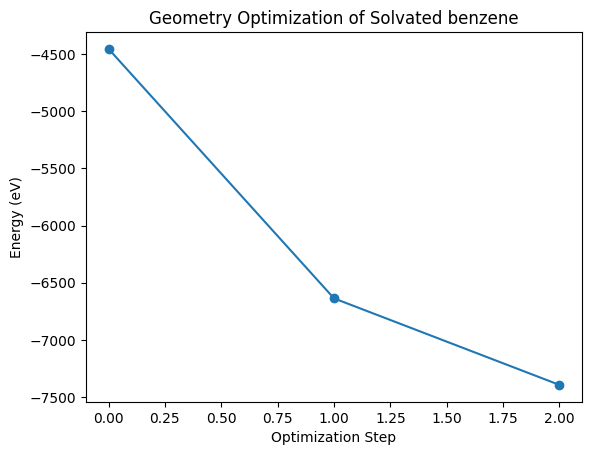

In [24]:
plt.figure()
plt.plot(range(len(energies)), energies, marker='o')
plt.xlabel('Optimization Step')
plt.ylabel('Energy (eV)')
plt.title('Geometry Optimization of Solvated benzene')
plt.savefig("optimization_energy.png")
plt.show()

#### Read geometry optimized trajectory 

In [25]:
frames = read('optimized.traj', index=':')
opt = Trajectory('optimized.traj')[-1]
opt.get_cell()
view(frames, viewer="ngl")

### 6. Run Molecular Dynamics 

#### Equilibration: Relax into a stable state before data collection

In [26]:
inp_md = '''
&FORCE_EVAL
  &DFT
    CHARGE 0
    &MGRID
      NGRIDS 4
      REL_CUTOFF 30
    &END MGRID
    &QS
      METHOD GPW
      EPS_DEFAULT 1.0E-12
      EXTRAPOLATION ASPC
    &END QS
    &SCF
      SCF_GUESS RESTART
      EPS_SCF 1.0E-8
      CHOLESKY INVERSE
      &DIAGONALIZATION
    	ALGORITHM STANDARD
      &END DIAGONALIZATION
      &MIXING
    	METHOD  BROYDEN_MIXING
    	ALPHA   0.05
    	BETA    1.5
    	NBROYDEN 16
      &END MIXING
    &END SCF
    &XC
      &XC_FUNCTIONAL PBE
      &END XC_FUNCTIONAL
      &VDW_POTENTIAL
	    POTENTIAL_TYPE PAIR_POTENTIAL
	    &PAIR_POTENTIAL
          PARAMETER_FILE_NAME dftd3.dat
          TYPE DFTD3
	      CALCULATE_C9_TERM .TRUE.
	      REFERENCE_C9_TERM .TRUE.
          REFERENCE_FUNCTIONAL PBE
	    &END PAIR_POTENTIAL
      &END VDW_POTENTIAL
    &END XC
  &END DFT
&END FORCE_EVAL

&GLOBAL
  RUN_TYPE MD
  PREFERRED_FFT_LIBRARY FFTW3
  FFTW_PLAN_TYPE PATIENT
  SAVE_MEM T
  &DBCSR
    MM_DRIVER BLAS
  &END DBCSR
  PREFERRED_DIAG_LIBRARY SL
&END GLOBAL 
'''

#### Create MD calculator for equilibration

In [27]:
calc_equil_md = CP2K(label='equil',
            cutoff=250,
            basis_set='SZV-MOLOPT-GTH',
            pseudo_potential='auto',
            charge=0,
            xc='PBE',
            print_level='LOW',
            max_scf=20,
            inp=inp_md)

opt.calc = calc_equil_md

#### Run Equilibration MD

In [28]:
MaxwellBoltzmannDistribution(opt, temperature_K=300)
mddyn_eql = NVTBerendsen(opt, timestep=0.5 * units.fs, temperature_K=300, taut=10 * units.fs, trajectory='equil.traj', logfile='equil.log', append_trajectory=True)
print("Running MD simulation...")
mddyn_eql.run(2)  # 200 steps = 100 fs
print("Simulation complete.")

# md_dyn = Langevin(opt.atoms, timestep=0.5 * units.fs, temperature_K=300.0, friction=0.01 / units.fs, trajectory='MDrun.traj')  # 0.5 fs
# mddyn = NVTBerendsen(opt.atoms, timestep = 0.5 * units.fs, temperature_K= 300.0, taut=0.5*1000*units.fs)
# mddyn = VelocityVerlet(optimized_snapshot, timestep = 0.5 * units.fs) 
# def print_status(a=atoms):
#    epot = a.get_potential_energy()
#    ekin = a.get_kinetic_energy()
#    print(f'Energy | Epot = {epot:.3f} eV | Ekin = {ekin:.3f} eV | Etot = {epot+ekin:.3f} eV')
# mddyn.attach(print_status, interval=1)

Running MD simulation...
Simulation complete.


#### Create MD calculator for production

In [32]:
calc_md = CP2K(label='prod',
            cutoff=250,
            basis_set='SZV-MOLOPT-GTH',
            pseudo_potential='auto',
            charge=0,
            xc='PBE',
            print_level='LOW',
            max_scf=20,
            inp=inp_md)

#### Run Production MD 

In [33]:
equil_traj= Trajectory('equil.traj')
equilibrated = equil_traj[-1]

equilibrated.calc = calc_md
proddyn = VelocityVerlet(equilibrated, timestep=0.5 * units.fs,
                         trajectory='prod.traj', logfile='prod.log', append_trajectory=True)

#proddyn.run(200000) #200ps
proddyn.run(2) #200ps

True

### 7. Visualize trajectory

In [35]:
frames = read('prod.traj', index=':')
view(frames, viewer="ngl")

### 8. Postprocessing

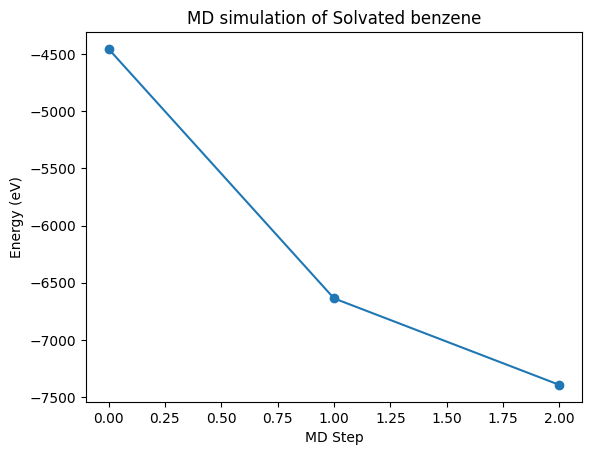

In [36]:
plt.figure()
plt.plot(range(len(energies)), energies, marker='o')
plt.xlabel('MD Step')
plt.ylabel('Energy (eV)')
plt.title('MD simulation of Solvated H3PO4')
plt.savefig("MD_energyprofile.png")
plt.show()